## 1. Import thư viện và thiết lập

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

# Thiết lập seed để có kết quả tái tạo được
manualSeed = 999
print("Random Seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Chọn device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Random Seed: 999
Using device: cuda


## 2. Cấu hình tham số

In [2]:
# Kích thước ảnh đầu vào (MNIST gốc là 28x28, resize lên 64x64)
IMG_SIZE = 64

# Số kênh ảnh (MNIST là ảnh grayscale nên chỉ có 1 kênh)
NUM_CHANNELS = 1

# Kích thước batch
BATCH_SIZE = 128

# Số features cơ bản cho Generator và Discriminator
NUM_FEATURES_G = 64  # Features cho Generator
NUM_FEATURES_D = 64  # Features cho Discriminator

# Kích thước latent vector (input noise)
LATENT_DIM = 100

# Số epochs huấn luyện
NUM_EPOCHS = 50

# Learning rate
LEARNING_RATE = 0.0002

# Beta1 cho Adam optimizer
BETA1 = 0.5

# Thư mục lưu checkpoint
CHECKPOINT_DIR = "./checkpoints_mnist"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Thư mục lưu ảnh sinh ra
OUTPUT_DIR = "./samples_mnist"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Tải và chuẩn bị dữ liệu MNIST

In [3]:
DATA_PATH = '/kaggle/input/qgans-mnist/classical_data_01_64x64.pt' 

try:
    # 1. Load file .pt
    saved_data = torch.load(DATA_PATH)
    
    # 2. Lấy Data và Label ra (Data đã được resize 64x64 và normalize sẵn)
    # Shape data sẽ là: (N_samples, 1, 64, 64)
    x_data = saved_data['data']
    y_labels = saved_data['labels']
    
    # Lưu ý: Data này đã được Normalize và Resize sẵn, không cần qua bước transform nữa
    print(f"✅ Đã load dataset từ file riêng: {x_data.shape}")

    # 3. Tạo TensorDataset 
    mnist_dataset = torch.utils.data.TensorDataset(x_data, y_labels)

    # 4. Tạo DataLoader 
    dataloader = torch.utils.data.DataLoader(
        mnist_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2
    )
    
    print(f"Số lượng ảnh trong dataset: {len(mnist_dataset)}")
    print(f"Số batch: {len(dataloader)}")

except FileNotFoundError:
    print(f"❌ LỖI: Không tìm thấy file '{DATA_PATH}'.")

✅ Đã load dataset từ file riêng: torch.Size([2000, 1, 64, 64])
Số lượng ảnh trong dataset: 2000
Số batch: 16


## 4. Hiển thị một số ảnh mẫu từ dataset

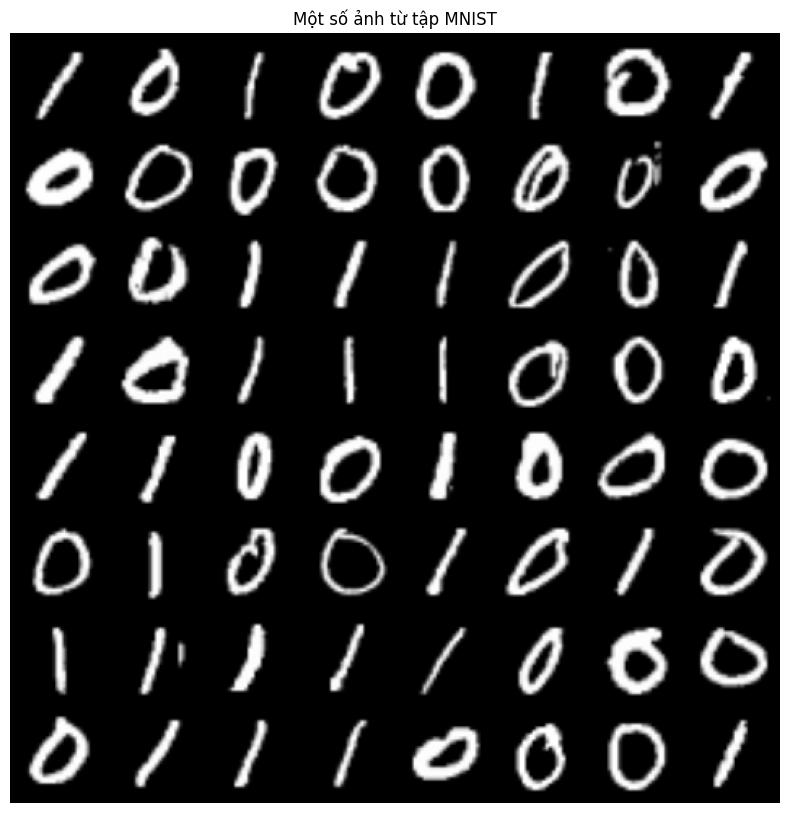

In [4]:
# Lấy một batch ảnh
real_batch = next(iter(dataloader))

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Một số ảnh từ tập MNIST")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0][:64], padding=2, normalize=True, nrow=8
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)
plt.show()

## 5. Định nghĩa kiến trúc Generator

In [5]:
class Generator(nn.Module):
    """
    Generator network cho DCGAN.
    Input: Latent vector z có kích thước (batch_size, LATENT_DIM, 1, 1)
    Output: Ảnh có kích thước (batch_size, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
    """

    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: z (LATENT_DIM x 1 x 1)
            # Output: (NUM_FEATURES_G*8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels=LATENT_DIM,
                out_channels=NUM_FEATURES_G * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_G * 8),
            nn.ReLU(True),
            # Output: (NUM_FEATURES_G*4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels=NUM_FEATURES_G * 8,
                out_channels=NUM_FEATURES_G * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_G * 4),
            nn.ReLU(True),
            # Output: (NUM_FEATURES_G*2) x 16 x 16
            nn.ConvTranspose2d(
                in_channels=NUM_FEATURES_G * 4,
                out_channels=NUM_FEATURES_G * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_G * 2),
            nn.ReLU(True),
            # Output: NUM_FEATURES_G x 32 x 32
            nn.ConvTranspose2d(
                in_channels=NUM_FEATURES_G * 2,
                out_channels=NUM_FEATURES_G,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_G),
            nn.ReLU(True),
            # Output: NUM_CHANNELS x 64 x 64
            nn.ConvTranspose2d(
                in_channels=NUM_FEATURES_G,
                out_channels=NUM_CHANNELS,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),  # Output trong khoảng [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

## 6. Định nghĩa kiến trúc Discriminator

In [6]:
class Discriminator(nn.Module):
    """
    Discriminator network cho DCGAN.
    Input: Ảnh có kích thước (batch_size, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
    Output: Xác suất ảnh là thật (batch_size, 1, 1, 1)
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: NUM_CHANNELS x 64 x 64
            # Output: NUM_FEATURES_D x 32 x 32
            nn.Conv2d(
                in_channels=NUM_CHANNELS,
                out_channels=NUM_FEATURES_D,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (NUM_FEATURES_D*2) x 16 x 16
            nn.Conv2d(
                in_channels=NUM_FEATURES_D,
                out_channels=NUM_FEATURES_D * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_D * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (NUM_FEATURES_D*4) x 8 x 8
            nn.Conv2d(
                in_channels=NUM_FEATURES_D * 2,
                out_channels=NUM_FEATURES_D * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_D * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (NUM_FEATURES_D*8) x 4 x 4
            nn.Conv2d(
                in_channels=NUM_FEATURES_D * 4,
                out_channels=NUM_FEATURES_D * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(NUM_FEATURES_D * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 1 x 1 x 1
            nn.Conv2d(
                in_channels=NUM_FEATURES_D * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

## 7. Khởi tạo trọng số

In [7]:
def weights_init(m):
    """
    Khởi tạo trọng số theo paper DCGAN.
    Conv và ConvTranspose: mean=0, std=0.02
    BatchNorm: mean=1, std=0.02
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 8. Tạo và khởi tạo mô hình

In [8]:
# Tạo Generator
netG = Generator().to(device)
netG.apply(weights_init)
print("Generator:")
print(netG)

print("\n" + "=" * 50 + "\n")

# Tạo Discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print("Discriminator:")
print(netD)

Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

## 9. Thiết lập Loss function và Optimizer

In [9]:
# Loss function - Binary Cross Entropy
criterion = nn.BCELoss()

# Tạo fixed noise để theo dõi quá trình học
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

# Labels
real_label = 1.0
fake_label = 0.0

# Optimizer cho Generator và Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

## 10. Vòng lặp huấn luyện

In [10]:
# Danh sách lưu trữ tiến trình
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Bắt đầu huấn luyện...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    pbar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Epoch {epoch+1}/{NUM_EPOCHS}",
    )

    for i, data in pbar:
        ############################
        # (1) Cập nhật Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        # Huấn luyện với ảnh thật
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        # Forward pass ảnh thật qua D
        output = netD(real_images).view(-1)
        # Tính loss cho ảnh thật
        errD_real = criterion(output, label)
        # Backward
        errD_real.backward()
        D_x = output.mean().item()

        # Huấn luyện với ảnh giả
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        # Sinh ảnh giả từ Generator
        fake = netG(noise)
        label.fill_(fake_label)
        # Phân loại ảnh giả với D
        output = netD(fake.detach()).view(-1)
        # Tính loss cho ảnh giả
        errD_fake = criterion(output, label)
        # Backward
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Tổng loss của D
        errD = errD_real + errD_fake
        # Cập nhật D
        optimizerD.step()

        ############################
        # (2) Cập nhật Generator: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # Generator muốn D nghĩ ảnh giả là thật
        # Forward pass ảnh giả qua D (đã cập nhật)
        output = netD(fake).view(-1)
        # Tính loss cho G
        errG = criterion(output, label)
        # Backward
        errG.backward()
        D_G_z2 = output.mean().item()
        # Cập nhật G
        optimizerG.step()

        # Cập nhật progress bar
        pbar.set_postfix(
            {
                "Loss_D": f"{errD.item():.4f}",
                "Loss_G": f"{errG.item():.4f}",
                "D(x)": f"{D_x:.4f}",
                "D(G(z))": f"{D_G_z1:.4f}/{D_G_z2:.4f}",
            }
        )

        # Lưu losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Lưu ảnh sinh ra mỗi 500 iterations
        if (iters % 500 == 0) or (
            (epoch == NUM_EPOCHS - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(
                torchvision.utils.make_grid(fake, padding=2, normalize=True, nrow=8)
            )

        iters += 1

    # Lưu checkpoint sau mỗi epoch
    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "generator_state_dict": netG.state_dict(),
                "discriminator_state_dict": netD.state_dict(),
                "optimizerG_state_dict": optimizerG.state_dict(),
                "optimizerD_state_dict": optimizerD.state_dict(),
                "G_losses": G_losses,
                "D_losses": D_losses,
            },
            f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pth",
        )
        print(f"\nĐã lưu checkpoint tại epoch {epoch+1}")

print("\n" + "=" * 60)
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện...


Epoch 5/50: 100%|██████████| 16/16 [00:02<00:00,  7.24it/s, Loss_D=0.6314, Loss_G=13.7676, D(x)=0.7582, D(G(z))=0.0003/0.0000]



Đã lưu checkpoint tại epoch 5


Epoch 10/50: 100%|██████████| 16/16 [00:02<00:00,  7.15it/s, Loss_D=0.3351, Loss_G=2.8158, D(x)=0.8810, D(G(z))=0.1628/0.0858]



Đã lưu checkpoint tại epoch 10


Epoch 15/50: 100%|██████████| 16/16 [00:02<00:00,  7.11it/s, Loss_D=0.0530, Loss_G=4.8896, D(x)=0.9780, D(G(z))=0.0293/0.0114]



Đã lưu checkpoint tại epoch 15


Epoch 20/50: 100%|██████████| 16/16 [00:02<00:00,  7.02it/s, Loss_D=4.2968, Loss_G=2.6465, D(x)=0.1050, D(G(z))=0.0002/0.1650]



Đã lưu checkpoint tại epoch 20


Epoch 25/50: 100%|██████████| 16/16 [00:02<00:00,  6.98it/s, Loss_D=1.4770, Loss_G=0.6747, D(x)=0.3713, D(G(z))=0.0604/0.5763]



Đã lưu checkpoint tại epoch 25


Epoch 30/50: 100%|██████████| 16/16 [00:02<00:00,  6.88it/s, Loss_D=0.1605, Loss_G=3.3304, D(x)=0.8989, D(G(z))=0.0411/0.0632]



Đã lưu checkpoint tại epoch 30


Epoch 35/50: 100%|██████████| 16/16 [00:02<00:00,  6.84it/s, Loss_D=1.0022, Loss_G=3.6407, D(x)=0.9346, D(G(z))=0.4661/0.0673]



Đã lưu checkpoint tại epoch 35


Epoch 40/50: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s, Loss_D=0.2896, Loss_G=2.2158, D(x)=0.8812, D(G(z))=0.1350/0.1659]



Đã lưu checkpoint tại epoch 40


Epoch 45/50: 100%|██████████| 16/16 [00:02<00:00,  6.74it/s, Loss_D=0.3238, Loss_G=2.9032, D(x)=0.8750, D(G(z))=0.1526/0.0796]



Đã lưu checkpoint tại epoch 45


Epoch 50/50: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s, Loss_D=0.3614, Loss_G=2.5249, D(x)=0.8241, D(G(z))=0.1268/0.1488]



Đã lưu checkpoint tại epoch 50

Huấn luyện hoàn tất!


## 11. Lưu mô hình cuối cùng

In [11]:
# Lưu mô hình cuối cùng
torch.save(netG.state_dict(), f"{CHECKPOINT_DIR}/generator_final.pth")
torch.save(netD.state_dict(), f"{CHECKPOINT_DIR}/discriminator_final.pth")
print("Đã lưu mô hình cuối cùng!")

Đã lưu mô hình cuối cùng!


## 12. Hiển thị Loss trong quá trình huấn luyện

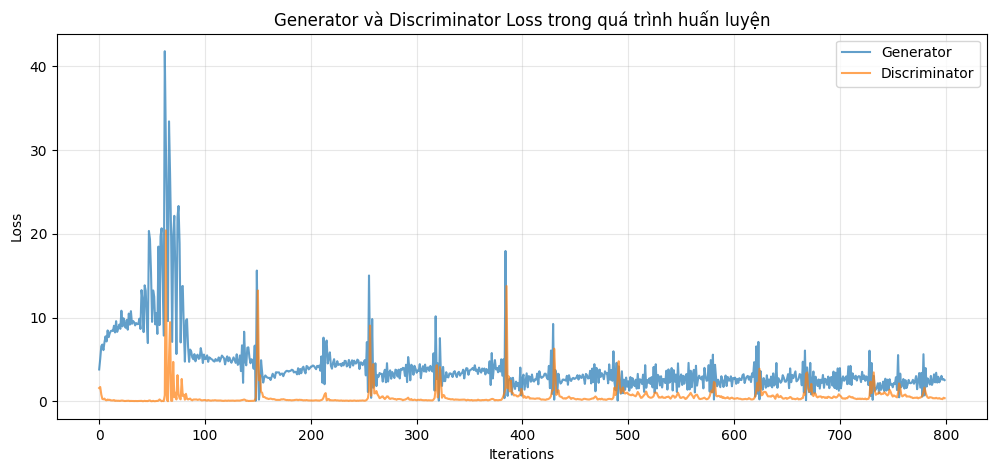

In [12]:
plt.figure(figsize=(12, 5))
plt.title("Generator và Discriminator Loss trong quá trình huấn luyện")
plt.plot(G_losses, label="Generator", alpha=0.7)
plt.plot(D_losses, label="Discriminator", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{OUTPUT_DIR}/training_loss.png", dpi=150, bbox_inches="tight")
plt.show()

## 13. Animation quá trình học của Generator

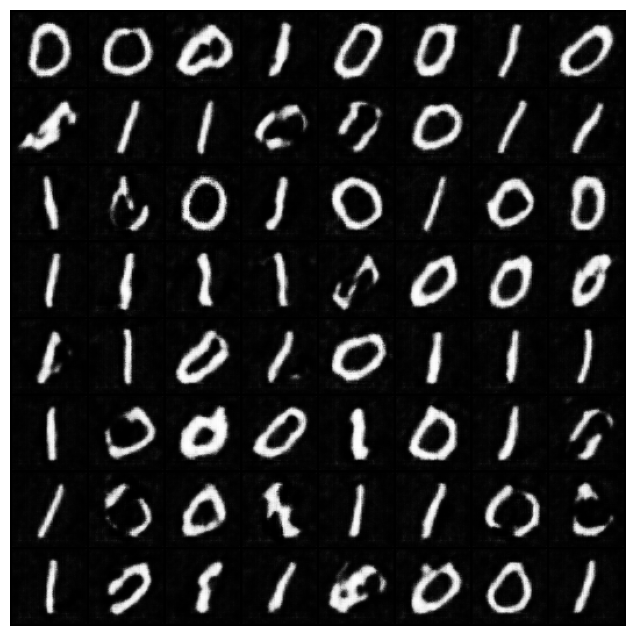

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True, cmap="gray")]
    for i in img_list
]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## 14. So sánh ảnh thật và ảnh giả

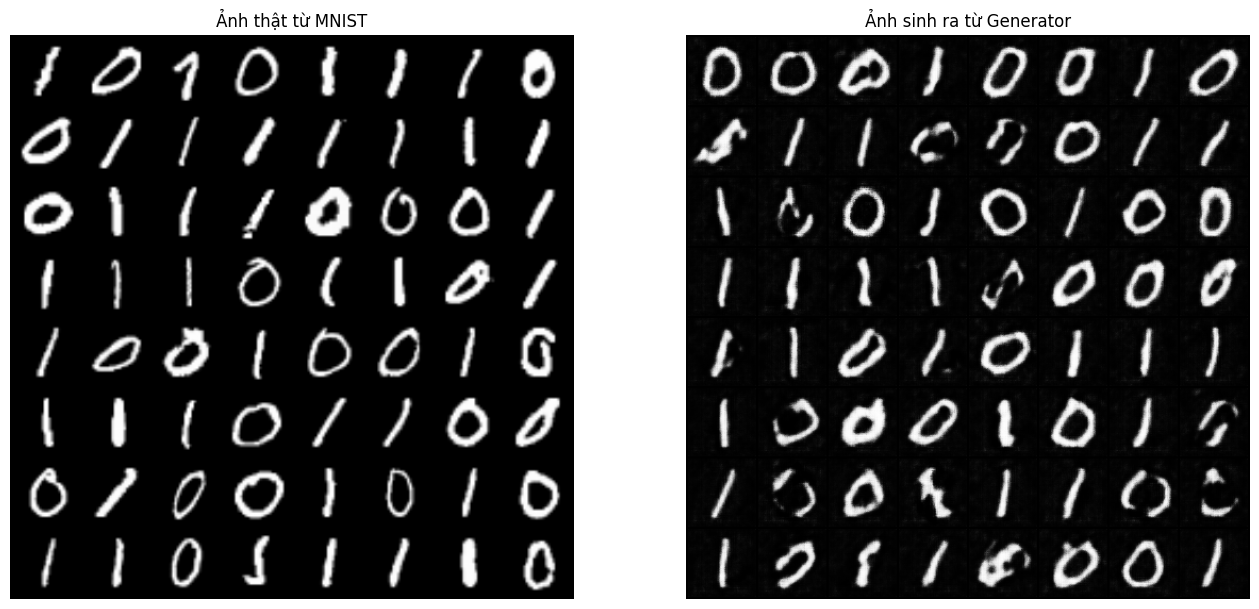

In [14]:
# Lấy batch ảnh thật
real_batch = next(iter(dataloader))

# Tạo figure so sánh
plt.figure(figsize=(16, 8))

# Ảnh thật
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Ảnh thật từ MNIST")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0][:64], padding=2, normalize=True, nrow=8
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)

# Ảnh giả
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Ảnh sinh ra từ Generator")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)), cmap="gray")

plt.savefig(f"{OUTPUT_DIR}/real_vs_fake.png", dpi=150, bbox_inches="tight")
plt.show()

---
# 🔮 INFERENCE - Sinh ảnh từ mô hình đã huấn luyện
---

## 15. Tải mô hình đã lưu (cho Inference)

In [15]:
def load_generator(checkpoint_path, device="cuda"):
    """
    Hàm tải Generator từ checkpoint.

    Args:
        checkpoint_path: Đường dẫn tới file checkpoint (.pth)
        device: 'cuda' hoặc 'cpu'

    Returns:
        Generator model đã tải trọng số
    """
    generator = Generator()
    generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
    generator.to(device)
    generator.eval()  # Chuyển sang chế độ evaluation
    return generator


# Tải generator đã huấn luyện
# Nếu bạn đang chạy sau khi huấn luyện, có thể dùng netG trực tiếp
# Nếu tải từ file, uncomment dòng dưới:
# netG_inference = load_generator(f"{CHECKPOINT_DIR}/generator_final.pth", device)

# Sử dụng model đã huấn luyện
netG_inference = netG
netG_inference.eval()
print("Đã tải Generator cho inference!")

Đã tải Generator cho inference!


## 16. Sinh ảnh đơn lẻ

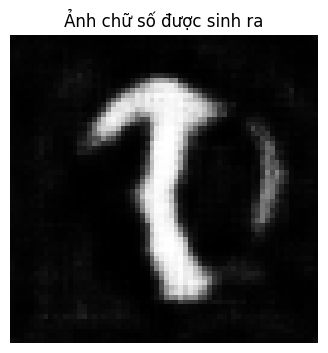

In [16]:
def generate_single_image(generator, device="cuda"):
    """
    Sinh một ảnh từ noise ngẫu nhiên.

    Args:
        generator: Mô hình Generator
        device: 'cuda' hoặc 'cpu'

    Returns:
        Ảnh numpy array (H, W)
    """
    with torch.no_grad():
        noise = torch.randn(1, LATENT_DIM, 1, 1, device=device)
        fake_image = generator(noise)
        # Chuyển từ [-1, 1] về [0, 1]
        fake_image = (fake_image + 1) / 2
        # Chuyển sang numpy
        fake_image = fake_image.squeeze().cpu().numpy()
    return fake_image


# Sinh và hiển thị một ảnh
generated_image = generate_single_image(netG_inference, device)

plt.figure(figsize=(4, 4))
plt.imshow(generated_image, cmap="gray")
plt.title("Ảnh chữ số được sinh ra")
plt.axis("off")
plt.show()

## 17. Sinh nhiều ảnh cùng lúc

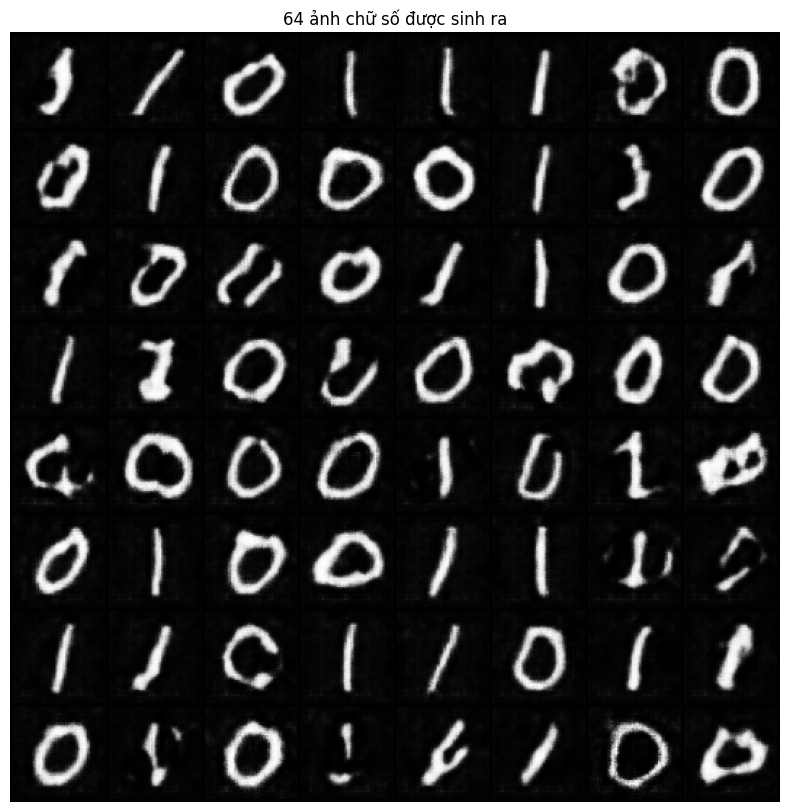

In [17]:
def generate_images(generator, num_images=16, device="cuda"):
    """
    Sinh nhiều ảnh từ noise ngẫu nhiên.

    Args:
        generator: Mô hình Generator
        num_images: Số lượng ảnh cần sinh
        device: 'cuda' hoặc 'cpu'

    Returns:
        Tensor ảnh (num_images, 1, H, W)
    """
    with torch.no_grad():
        noise = torch.randn(num_images, LATENT_DIM, 1, 1, device=device)
        fake_images = generator(noise)
    return fake_images


# Sinh 64 ảnh
num_generate = 64
generated_images = generate_images(netG_inference, num_generate, device)

# Hiển thị dạng grid
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title(f"{num_generate} ảnh chữ số được sinh ra")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            generated_images, padding=2, normalize=True, nrow=8
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)
plt.savefig(f"{OUTPUT_DIR}/generated_digits.png", dpi=150, bbox_inches="tight")
plt.show()

## 18. Latent Space Interpolation (Nội suy trong không gian ẩn)

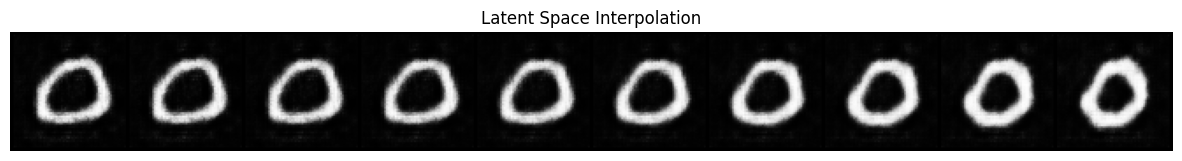

In [18]:
def interpolate_latent(generator, z1, z2, num_steps=10, device="cuda"):
    """
    Nội suy tuyến tính giữa 2 điểm trong không gian latent.

    Args:
        generator: Mô hình Generator
        z1, z2: Hai latent vectors
        num_steps: Số bước nội suy
        device: 'cuda' hoặc 'cpu'

    Returns:
        List các ảnh nội suy
    """
    images = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, num_steps):
            z = (1 - alpha) * z1 + alpha * z2
            fake_image = generator(z)
            images.append(fake_image)
    return torch.cat(images, dim=0)


# Tạo 2 latent vectors ngẫu nhiên
z1 = torch.randn(1, LATENT_DIM, 1, 1, device=device)
z2 = torch.randn(1, LATENT_DIM, 1, 1, device=device)

# Nội suy
interpolated_images = interpolate_latent(
    netG_inference, z1, z2, num_steps=10, device=device
)

# Hiển thị
plt.figure(figsize=(15, 2))
plt.axis("off")
plt.title("Latent Space Interpolation")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            interpolated_images, padding=2, normalize=True, nrow=10
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)
plt.savefig(f"{OUTPUT_DIR}/interpolation.png", dpi=150, bbox_inches="tight")
plt.show()

## 19. Sinh ảnh với seed cố định (tái tạo được)

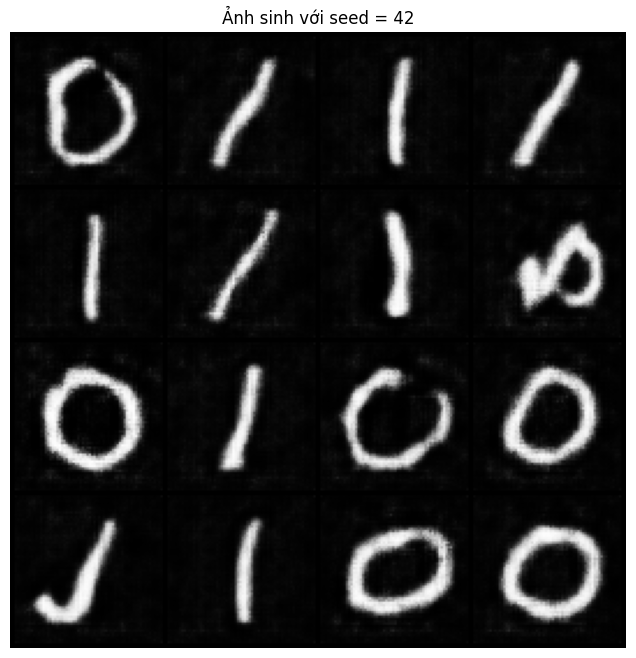

Hai lần sinh với cùng seed có kết quả giống nhau: False


In [19]:
def generate_with_seed(generator, seed, num_images=16, device="cuda"):
    """
    Sinh ảnh với seed cố định để có kết quả tái tạo được.

    Args:
        generator: Mô hình Generator
        seed: Seed ngẫu nhiên
        num_images: Số lượng ảnh
        device: 'cuda' hoặc 'cpu'

    Returns:
        Tensor ảnh
    """
    torch.manual_seed(seed)
    with torch.no_grad():
        noise = torch.randn(num_images, LATENT_DIM, 1, 1, device=device)
        fake_images = generator(noise)
    return fake_images


# Sinh với seed = 42
seed_images = generate_with_seed(netG_inference, seed=42, num_images=16, device=device)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Ảnh sinh với seed = 42")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            seed_images, padding=2, normalize=True, nrow=4
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)
plt.show()

# Chạy lại với cùng seed sẽ cho kết quả giống hệt
seed_images_again = generate_with_seed(
    netG_inference, seed=42, num_images=16, device=device
)
print(
    "Hai lần sinh với cùng seed có kết quả giống nhau:",
    torch.allclose(seed_images, seed_images_again),
)

## 20. Lưu ảnh sinh ra

In [20]:
def save_generated_images(
    generator, num_images=100, output_dir="./generated_mnist", device="cuda"
):
    """
    Sinh và lưu nhiều ảnh vào thư mục.

    Args:
        generator: Mô hình Generator
        num_images: Số lượng ảnh cần sinh
        output_dir: Thư mục lưu ảnh
        device: 'cuda' hoặc 'cpu'
    """
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for i in tqdm(range(num_images), desc="Generating images"):
            noise = torch.randn(1, LATENT_DIM, 1, 1, device=device)
            fake_image = generator(noise)
            # Chuyển từ [-1, 1] về [0, 1]
            fake_image = (fake_image + 1) / 2
            # Lưu ảnh
            torchvision.utils.save_image(
                fake_image, f"{output_dir}/generated_{i:04d}.png"
            )

    print(f"Đã lưu {num_images} ảnh vào {output_dir}")


# Sinh và lưu 100 ảnh
save_generated_images(
    netG_inference, num_images=100, output_dir=f"{OUTPUT_DIR}/individual", device=device
)

Generating images: 100%|██████████| 100/100 [00:00<00:00, 526.19it/s]

Đã lưu 100 ảnh vào ./samples_mnist/individual


## 21. Script Inference độc lập (có thể copy ra file .py riêng)

In [21]:
# =============================================================================
# INFERENCE SCRIPT - Có thể copy đoạn này ra file riêng (inference.py)
# =============================================================================

inference_script = """
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Tham số
LATENT_DIM = 100
NUM_FEATURES_G = 64
NUM_CHANNELS = 1

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, NUM_FEATURES_G * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NUM_FEATURES_G * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(NUM_FEATURES_G * 8, NUM_FEATURES_G * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_FEATURES_G * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(NUM_FEATURES_G * 4, NUM_FEATURES_G * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_FEATURES_G * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(NUM_FEATURES_G * 2, NUM_FEATURES_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NUM_FEATURES_G),
            nn.ReLU(True),
            nn.ConvTranspose2d(NUM_FEATURES_G, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

def main():
    parser = argparse.ArgumentParser(description="DCGAN MNIST Inference")
    parser.add_argument("--checkpoint", type=str, required=True, help="Path to generator checkpoint")
    parser.add_argument("--num_images", type=int, default=64, help="Number of images to generate")
    parser.add_argument("--output", type=str, default="generated.png", help="Output image path")
    parser.add_argument("--seed", type=int, default=None, help="Random seed")
    args = parser.parse_args()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    generator = Generator()
    generator.load_state_dict(torch.load(args.checkpoint, map_location=device))
    generator.to(device)
    generator.eval()
    
    # Set seed if provided
    if args.seed is not None:
        torch.manual_seed(args.seed)
    
    # Generate images
    with torch.no_grad():
        noise = torch.randn(args.num_images, LATENT_DIM, 1, 1, device=device)
        fake_images = generator(noise)
    
    # Save grid
    torchvision.utils.save_image(fake_images, args.output, normalize=True, nrow=8)
    print(f"Saved {args.num_images} generated images to {args.output}")

if __name__ == "__main__":
    main()
"""

# Lưu script ra file
with open("inference_dcgan_mnist.py", "w") as f:
    f.write(inference_script)

print("Đã lưu script inference ra file 'inference_dcgan_mnist.py'")
print("\nCách sử dụng:")
print(
    "python inference_dcgan_mnist.py --checkpoint ./checkpoints_mnist/generator_final.pth --num_images 64 --output output.png"
)

Đã lưu script inference ra file 'inference_dcgan_mnist.py'

Cách sử dụng:
python inference_dcgan_mnist.py --checkpoint ./checkpoints_mnist/generator_final.pth --num_images 64 --output output.png


## Tổng kết

Notebook này đã triển khai đầy đủ:

1. **Huấn luyện DCGAN trên MNIST**:
   - Generator: Chuyển đổi latent vector (100 chiều) thành ảnh 64x64
   - Discriminator: Phân biệt ảnh thật và ảnh giả
   - Sử dụng Binary Cross Entropy Loss
   - Adam optimizer với learning rate = 0.0002

2. **Inference**:
   - `generate_single_image()`: Sinh một ảnh
   - `generate_images()`: Sinh nhiều ảnh
   - `generate_with_seed()`: Sinh ảnh với seed cố định
   - `interpolate_latent()`: Nội suy trong không gian latent
   - `save_generated_images()`: Lưu ảnh sinh ra
   - Script độc lập `inference_dcgan_mnist.py` để inference từ command line